In [1]:
import h5py
import numpy as np
import os
import cv2
from pathlib import Path

# Example paths (adjust as needed)
# angiographyDataFile = "/path/to/your/angiography.h5"
# nnUNetRawFolder = "/path/to/nnUNet/raw/folder"
angiographyDataFile=str(Path.home() / "Angiostore/WebknossosAnnotationsRevisedUnitized-5-Bitfield.h5")

annotationBitfieldDataFile = str(Path.home()/ "Angiostore/WebknossosAnnotationsRevisedUnitized-5-Bitfield.h5")
annotationDataFile = str(Path.home()/ "Angiostore/WebknossosAnnotationsRevisedUnitized-5.h5")
annotationIndicizedDataFile = str(Path.home()/ "Angiostore/WebknossosAnnotationsRevisedIndicized-3.h5")
nnUNetRawFolder = str(Path.home()/ "Angiostore/nnUnet_raw")


In [2]:
def get_common_keys(angiographyDataFile, annotationDataFile):
    """
    Get the intersection of keys between the two HDF5 files
    """
    with h5py.File(angiographyDataFile, 'r') as f_angio, \
         h5py.File(annotationDataFile, 'r') as f_anno:
        
        angio_keys = set(f_angio.keys())
        anno_keys = set(f_anno.keys())
        common_keys = sorted(list(angio_keys.intersection(anno_keys)))
        
        print(f"Angiography keys: {len(angio_keys)}")
        print(f"Annotation keys: {len(anno_keys)}")
        print(f"Common keys: {len(common_keys)}")
        
        return common_keys


In [3]:
# Get common keys first
common_keys = get_common_keys(angiographyDataFile, annotationBitfieldDataFile)

# If you want to see the keys before proceeding
print("Common keys:", common_keys)

Angiography keys: 147
Annotation keys: 147
Common keys: 147
Common keys: ['01_Case_CSF8U1R1_14', '01_Case_CSF8U1RQ_13', '03_Case_CSF8UKA1_2', '03_Case_CSF8UKA5_4', '03_Case_CSF8UKA9_1', '03_Case_CSF8UKAH_5', '06_Case_CSF8W343_9', '06_Case_CSF8W34C_7', '07_Case_CSF8W6GE_7', '07_Case_CSF8W6GK_4', '07_Case_CSF8W6GS_8', '07_Case_CSF8W6GY_6', '10_Case_CSF8WNXU_5', '10_Case_CSF8WNY6_1', '11_Case_CSF8X226_2', '12_Case_CSF8XAD2_23', '12_Case_CSF8XADW_10', '13_Case_CSVS1XAP_1', '13_Case_CSVS1XAU_6', '13_Case_CSVS1XB4_2', '13_Case_CSVS1XBI_4', '14_Case_CSVS23F6_14', '14_Case_CSVS23FO_5', '14_Case_CSVS23FS_4', '15_Case_CSVS35IV_3', '20_Case_CSVS6EJ5_7', '20_Case_CSVS6EJE_1', '20_Case_CSVS6EJZ_5', '20_Case_CSVS6EKN_3', 'Angios_005_rev', 'Angios_006_rev', 'Angios_007_rev', 'Angios_013_rev', 'Angios_015_rev', 'Angios_016_rev', 'Angios_021_rev', 'Angios_022_rev', 'Angios_030_rev', 'Angios_031_rev', 'Angios_032_rev', 'Angios_033_rev', 'Angios_048_rev', 'Angios_061_rev', 'Angios_063_rev', 'Angios_065_r

In [4]:
def get_allowed_frame_keys(angiographyDataFile: str, annotationBitfieldDataFile: str, common_keys: list[str]) -> list[tuple[str, int]]:
    """
    Get allowed frame keys by finding the minimum number of frames between angiography and annotation data
    for each common key, and generating valid center indices.

    Args:
        angiographyDataFile: Path to the angiography HDF5 file
        annotationBitfieldDataFile: Path to the annotation bitfield HDF5 file
        common_keys: List of keys common to both HDF5 files

    Returns:
        List of tuples containing (dataset_name, center_idx) for valid frames
    """
    frameKeys = []
    
    with h5py.File(angiographyDataFile, 'r') as f_angio, \
         h5py.File(annotationBitfieldDataFile, 'r') as f_anno:
        
        for dataset_name in common_keys:
            # Get number of frames from both files
            angio_frames = f_angio[dataset_name].shape[0]
            anno_frames = f_anno[dataset_name].shape[0]
            
            # Find minimum number of frames
            min_frames = min(angio_frames, anno_frames)
            
            # Generate valid center indices (2 to min_frames-2)
            for center_idx in range(2, min_frames - 2):
                frameKeys.append((dataset_name, center_idx))
    
    return frameKeys


In [5]:
# Let's get the allowed frame keys
frameKeys = get_allowed_frame_keys(angiographyDataFile, annotationBitfieldDataFile, common_keys)


In [6]:
len(frameKeys)

9653

In [7]:

def export_angiography_to_nnunet(angiographyDataFile, nnUNetRawFolder, frameKeys):
    """
    Modified to only process common keys
    """
    images_dir = os.path.join(nnUNetRawFolder, 'imagesTr')
    Path(images_dir).mkdir(parents=True, exist_ok=True)
    
    with h5py.File(angiographyDataFile, 'r') as f:
        blockCounter = 0
        
        # Only iterate through common keys
        for dataset_name, center_idx in frameKeys:
            print(f"Processing angiogram dataset: {dataset_name} center_idx: {center_idx}")
            angio_data = f[dataset_name][:]
            frame_indices = range(center_idx - 2, center_idx + 3)
            frames = angio_data[frame_indices]
                
            for frame_num, frame in enumerate(frames):
                if frame.dtype != np.uint8:
                    if frame.max() > 1:
                        frame = (frame / frame.max() * 255).astype(np.uint8)
                    else:
                        frame = (frame * 255).astype(np.uint8)
                    
                filename = f'Angios_{blockCounter:04d}_{frame_num:04d}.png'
                filepath = os.path.join(images_dir, filename)
                cv2.imwrite(filepath, frame)
                
            blockCounter += 1
        
    print(f"Exported {blockCounter} sets of 5 frames each")
    print(f"Total number of PNG files created: {blockCounter * 5}")
    return blockCounter


In [8]:
blockCounter = export_angiography_to_nnunet(angiographyDataFile, nnUNetRawFolder, frameKeys)


Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 2
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 3
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 4
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 5
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 6
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 7
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 8
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 9
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 10
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 11
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 12
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 13
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 14
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 15
Processing angiogram dataset: 01_Case_CSF8U1R1_14 center_idx: 16
Processing angiogram dataset: 01_

In [9]:
# ... existing code ...

def bitfield_to_channels(bitfield_array: np.ndarray) -> np.ndarray:
    """
    Transform a 3D array of uint8 bitfields into a 4D array of separate class channels.
    
    Args:
        bitfield_array: Input array of shape (frames, height, width) containing uint8 bitfields
        
    Returns:
        np.ndarray: Output array of shape (8, frames, height, width) where each channel
                   represents the presence of a specific class (bit position)
                   
    Example:
        >>> input_array = np.array([[[1, 2], [3, 4]]], dtype=np.uint8)
        >>> output = bitfield_to_channels(input_array)
        >>> # output[0] will be the mask for bit 0
        >>> # output[1] will be the mask for bit 1
        >>> # etc.
    """
    # Get the shape of the input array
    frames, height, width = bitfield_array.shape
    
    # Initialize output array with shape (8, frames, height, width)
    output = np.zeros((8, frames, height, width), dtype=np.uint8)
    
    # For each bit position (0-7)
    for bit in range(8):
        # Create a mask for this bit position
        mask = 1 << bit
        # Check if the bit is set in each position
        output[bit] = (bitfield_array & mask).astype(bool).astype(np.uint8)
    
    return output

# Example usage:
# channels = bitfield_to_channels(example_data)
# print(f"Input shape: {example_data.shape}")
# print(f"Output shape: {channels.shape}")
# print(f"Number of non-zero pixels per channel:")
# for i in range(8):
#     print(f"Channel {i}: {np.sum(channels[i])}")

In [10]:
def expandBitfieldAnnotationFile(annotationBitfieldDataFile, annotationDataFile):
    # open both files
    with h5py.File(annotationBitfieldDataFile, 'r') as f_bitfield, \
         h5py.File(annotationDataFile, 'w') as f_anno:
        
        # get the keys
        bitfield_keys = list(f_bitfield.keys())
        # Process each dataset
        for dataset_name in bitfield_keys:
            print(f"Processing dataset: {dataset_name}")
            
            # Read input data
            data = f_bitfield[dataset_name][:]
            print(f"Input shape: {data.shape}")
            
            # Transform to channels
            channels = bitfield_to_channels(data)[:4][::-1]  # Keep only first 4 channels and reverse their order to give background, catheter, vessel, stenosis, stent.
            # Add background channel (1 where all channels are 0)
            background = np.all(channels == 0, axis=0).astype(np.uint8)
            channels = np.concatenate([background[np.newaxis, ...], channels], axis=0)
            print(f"Channels shape: {channels.shape}")
            
            # Create output dataset
            output_shape = channels.shape
            dset_out = f_anno.create_dataset(
                dataset_name,
                output_shape,
                dtype=np.uint8
            )
            
            # Write transformed data
            dset_out[:] = channels

In [11]:
# Example usage:


expandBitfieldAnnotationFile(annotationBitfieldDataFile, annotationDataFile)

Processing dataset: 01_Case_CSF8U1R1_14
Input shape: (39, 512, 512)
Channels shape: (5, 39, 512, 512)
Processing dataset: 01_Case_CSF8U1RQ_13
Input shape: (50, 512, 512)
Channels shape: (5, 50, 512, 512)
Processing dataset: 03_Case_CSF8UKA1_2
Input shape: (44, 512, 512)
Channels shape: (5, 44, 512, 512)
Processing dataset: 03_Case_CSF8UKA5_4
Input shape: (62, 512, 512)
Channels shape: (5, 62, 512, 512)
Processing dataset: 03_Case_CSF8UKA9_1
Input shape: (46, 512, 512)
Channels shape: (5, 46, 512, 512)
Processing dataset: 03_Case_CSF8UKAH_5
Input shape: (70, 512, 512)
Channels shape: (5, 70, 512, 512)
Processing dataset: 06_Case_CSF8W343_9
Input shape: (53, 512, 512)
Channels shape: (5, 53, 512, 512)
Processing dataset: 06_Case_CSF8W34C_7
Input shape: (44, 512, 512)
Channels shape: (5, 44, 512, 512)
Processing dataset: 07_Case_CSF8W6GE_7
Input shape: (103, 512, 512)
Channels shape: (5, 103, 512, 512)
Processing dataset: 07_Case_CSF8W6GK_4
Input shape: (68, 512, 512)
Channels shape: (5, 

In [12]:
def indicize_annotation(data):
        catheter = data[1]
        vessel =  2 * (data[2] - data[2]*data[3]) 
        result = catheter + vessel - data[1]*data[2] 
        
        return result

In [13]:

def indicize_annotations(annotationDataFile, annotationIndicizedDataFile):
    """
    Transform 5-channel unitized annotations to single-channel indicized format.
    
    Rules:
    (0,0,0,*,*) -> 0  # background
    (0,1,0,*,*) -> 1  # catheter
    (0,0,1,0,*) -> 2  # vessel
    (0,0,*,1,*) -> 0  # stenosis (maps to background)
    """
    
    # Open both files
    with h5py.File(annotationDataFile, 'r') as f_in, \
         h5py.File(annotationIndicizedDataFile, 'w') as f_out:
        
        # Process each dataset
        for dataset_name in f_in.keys():
            print(f"Processing dataset: {dataset_name}")
            
            # Read input data
            data = f_in[dataset_name][:]
            print(f"Dataset shape: {data.shape}")
            # channels = bitfield_to_channels(data)
            # print(f"channels shape: {channels.shape}")
            indicized = indicize_annotation(data)
            print(f"Indicized shape: {indicized.shape}")
            
            # Create output dataset
            output_shape = indicized.shape
            dset_out = f_out.create_dataset(
                dataset_name,
                output_shape,
                dtype=np.uint8
            )
            
            # Write transformed data
            dset_out[:] = indicized
            
            # Verify unique values
            unique_values = np.unique(dset_out[:])
            print(f"  Dataset {dataset_name} unique values: {unique_values}")
            
        print("Transformation complete!")

# Example usage:
# transform_annotations(annotationDataFile, annotationIndicizedDataFile)

# For debugging, let's also print the shape of the first dataset
with h5py.File(annotationDataFile, 'r') as f:
    first_dataset_name = list(f.keys())[0]
    first_dataset = f[first_dataset_name][:]
    print(f"First dataset shape: {first_dataset.shape}")

First dataset shape: (5, 39, 512, 512)


In [14]:
# Example paths (adjust as needed)
# annotationDataFile = "/path/to/5channel/annotations.h5"
# annotationIndicizedDataFile = "/path/to/output/indicized_annotations.h5"

indicize_annotations(annotationDataFile, annotationIndicizedDataFile)

Processing dataset: 01_Case_CSF8U1R1_14
Dataset shape: (5, 39, 512, 512)
Indicized shape: (39, 512, 512)
  Dataset 01_Case_CSF8U1R1_14 unique values: [0 1 2]
Processing dataset: 01_Case_CSF8U1RQ_13
Dataset shape: (5, 50, 512, 512)
Indicized shape: (50, 512, 512)
  Dataset 01_Case_CSF8U1RQ_13 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKA1_2
Dataset shape: (5, 44, 512, 512)
Indicized shape: (44, 512, 512)
  Dataset 03_Case_CSF8UKA1_2 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKA5_4
Dataset shape: (5, 62, 512, 512)
Indicized shape: (62, 512, 512)
  Dataset 03_Case_CSF8UKA5_4 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKA9_1
Dataset shape: (5, 46, 512, 512)
Indicized shape: (46, 512, 512)
  Dataset 03_Case_CSF8UKA9_1 unique values: [0 1 2]
Processing dataset: 03_Case_CSF8UKAH_5
Dataset shape: (5, 70, 512, 512)
Indicized shape: (70, 512, 512)
  Dataset 03_Case_CSF8UKAH_5 unique values: [0 1 2]
Processing dataset: 06_Case_CSF8W343_9
Dataset shape: (5, 53

In [15]:
def get_hdf5_keys(hdf5_file: str) -> list[str]:
    """
    Get list of dataset keys in an HDF5 file.

    Args:
        hdf5_file: Path to the HDF5 file

    Returns:
        list[str]: List of dataset keys in the file
    """
    with h5py.File(hdf5_file, 'r') as f:
        keys = list(f.keys())
        print(f"Keys in {hdf5_file}:")
        for key in keys:
            print(f"  {key}")
        return keys

# Get keys from annotationIndicizedDataFile
keys = get_hdf5_keys(annotationIndicizedDataFile)


Keys in /home/billb/Angiostore/WebknossosAnnotationsRevisedIndicized-3.h5:
  01_Case_CSF8U1R1_14
  01_Case_CSF8U1RQ_13
  03_Case_CSF8UKA1_2
  03_Case_CSF8UKA5_4
  03_Case_CSF8UKA9_1
  03_Case_CSF8UKAH_5
  06_Case_CSF8W343_9
  06_Case_CSF8W34C_7
  07_Case_CSF8W6GE_7
  07_Case_CSF8W6GK_4
  07_Case_CSF8W6GS_8
  07_Case_CSF8W6GY_6
  10_Case_CSF8WNXU_5
  10_Case_CSF8WNY6_1
  11_Case_CSF8X226_2
  12_Case_CSF8XAD2_23
  12_Case_CSF8XADW_10
  13_Case_CSVS1XAP_1
  13_Case_CSVS1XAU_6
  13_Case_CSVS1XB4_2
  13_Case_CSVS1XBI_4
  14_Case_CSVS23F6_14
  14_Case_CSVS23FO_5
  14_Case_CSVS23FS_4
  15_Case_CSVS35IV_3
  20_Case_CSVS6EJ5_7
  20_Case_CSVS6EJE_1
  20_Case_CSVS6EJZ_5
  20_Case_CSVS6EKN_3
  Angios_005_rev
  Angios_006_rev
  Angios_007_rev
  Angios_013_rev
  Angios_015_rev
  Angios_016_rev
  Angios_021_rev
  Angios_022_rev
  Angios_030_rev
  Angios_031_rev
  Angios_032_rev
  Angios_033_rev
  Angios_048_rev
  Angios_061_rev
  Angios_063_rev
  Angios_065_rev
  Angios_067_rev
  Angios_072_rev
  Ang

In [16]:
len(keys)

147

In [17]:
import random
def get_dataset_data(hdf5_file: str, key: str) -> np.ndarray:
    """
    Get data from a specific dataset in an HDF5 file.

    Args:
        hdf5_file: Path to the HDF5 file
        key: Key of the dataset to retrieve

    Returns:
        np.ndarray: Data from the specified dataset
    """
    with h5py.File(hdf5_file, 'r') as f:
        data = f[key][:]
        print(f"Shape of dataset {key}: {data.shape}")
        return data

# Get data for "Napari_9_rev" dataset
key = random.choice(keys)
example_data = get_dataset_data(annotationIndicizedDataFile, "Narapi_34_rev")
print(key, example_data.shape)


Shape of dataset Narapi_34_rev: (62, 512, 512)
Angios_072_rev (62, 512, 512)


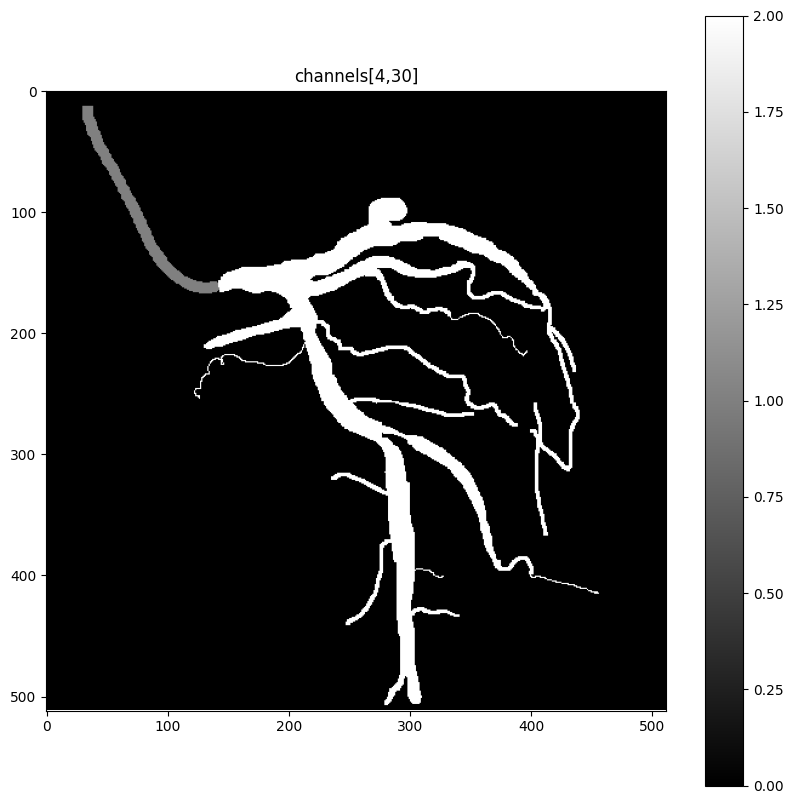

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(example_data[30], cmap='gray')
plt.colorbar()
plt.title('channels[4,30]')
plt.axis('on')
plt.show()


In [19]:
# Tabulate unique values and their counts in inmdi
unique_values, counts = np.unique(example_data, return_counts=True)
print("Value\tCount")
print("-----\t-----")
for val, count in zip(unique_values, counts):
    print(f"{val}\t{count}")


Value	Count
-----	-----
0	15290076
1	113506
2	849346


In [20]:

def export_annotations_to_nnunet(annotationIndicizedDataFile, nnUNetRawFolder, frameKeys):
    """
    Modified to only process common keys and verify count matches angiography
    """
    labels_dir = os.path.join(nnUNetRawFolder, 'labelsTr')
    Path(labels_dir).mkdir(parents=True, exist_ok=True)
    
    with h5py.File(annotationIndicizedDataFile, 'r') as f:
        blockCounter = 0
        
        # Only iterate through common keys
        for dataset_name, center_idx in frameKeys:
            print(f"Processing annotation dataset: {dataset_name} center_idx={center_idx}")
            # Get the shape of the dataset to check bounds
            dataset_shape = f[dataset_name].shape
            if center_idx >= dataset_shape[0]:
                raise IndexError(f"Index {center_idx} out of range for dataset {dataset_name} (0-{dataset_shape[0]-1})")
            anno_data = f[dataset_name][center_idx]
            
            filename = f'Angios_{blockCounter:04d}.png'
            filepath = os.path.join(labels_dir, filename)
            cv2.imwrite(filepath, anno_data)
                
            blockCounter += 1
        
        print(f"Exported {blockCounter} label files")
        
        # Verify we have the same number of cases as angiography
        assert blockCounter == len(frameKeys), \
            f"Mismatch in number of cases: Angiography had {len(frameKeys)}, Annotations had {blockCounter}"


In [21]:
# Print first 50 frame keys to inspect the data
print("First 50 frame keys:")
for i, (dataset_name, center_idx) in enumerate(frameKeys[:50]):
    print(f"{i}: {dataset_name}, center_idx={center_idx}")


First 50 frame keys:
0: 01_Case_CSF8U1R1_14, center_idx=2
1: 01_Case_CSF8U1R1_14, center_idx=3
2: 01_Case_CSF8U1R1_14, center_idx=4
3: 01_Case_CSF8U1R1_14, center_idx=5
4: 01_Case_CSF8U1R1_14, center_idx=6
5: 01_Case_CSF8U1R1_14, center_idx=7
6: 01_Case_CSF8U1R1_14, center_idx=8
7: 01_Case_CSF8U1R1_14, center_idx=9
8: 01_Case_CSF8U1R1_14, center_idx=10
9: 01_Case_CSF8U1R1_14, center_idx=11
10: 01_Case_CSF8U1R1_14, center_idx=12
11: 01_Case_CSF8U1R1_14, center_idx=13
12: 01_Case_CSF8U1R1_14, center_idx=14
13: 01_Case_CSF8U1R1_14, center_idx=15
14: 01_Case_CSF8U1R1_14, center_idx=16
15: 01_Case_CSF8U1R1_14, center_idx=17
16: 01_Case_CSF8U1R1_14, center_idx=18
17: 01_Case_CSF8U1R1_14, center_idx=19
18: 01_Case_CSF8U1R1_14, center_idx=20
19: 01_Case_CSF8U1R1_14, center_idx=21
20: 01_Case_CSF8U1R1_14, center_idx=22
21: 01_Case_CSF8U1R1_14, center_idx=23
22: 01_Case_CSF8U1R1_14, center_idx=24
23: 01_Case_CSF8U1R1_14, center_idx=25
24: 01_Case_CSF8U1R1_14, center_idx=26
25: 01_Case_CSF8U1R1_1

In [22]:
export_annotations_to_nnunet(annotationIndicizedDataFile, nnUNetRawFolder, frameKeys)

Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=2
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=3
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=4
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=5
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=6
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=7
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=8
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=9
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=10
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=11
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=12
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=13
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=14
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=15
Processing annotation dataset: 01_Case_CSF8U1R1_14 center_idx=16
Processing annotation dataset: 01

In [23]:
len(frameKeys)

9653

In [24]:
# ... existing code ...

from datetime import datetime

# Get current timestamp in a human-readable format
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

datasetJson = {
    "_comment": f"Dataset contains 5-channel angiography data at 7.5Hz (every other frame) with 5-frame neighborhoods. Labels include background (0), C (1), and V (2). Data sourced from WebknossosAngiogramsRevisedUInt8List.h5 and WebknossosAnnotationsRevisedIndicized-3.h5. Generated on {timestamp}.",
    "channel_names": {
        "0": "0",
        "1": "1",
        "2": "2",
        "3": "3",
        "4": "4"
    },
    "labels": {
        "background": 0,
        "catheter": 1,
        "vessel": 2
    },
    "numTraining": len(frameKeys),
    "file_ending": ".png"
}

# Write the dataset.json file
import json
dataset_json_path = os.path.join(nnUNetRawFolder, 'dataset.json')
with open(dataset_json_path, 'w') as f:
    json.dump(datasetJson, f, indent=4)

print(f"Created dataset.json at {dataset_json_path}")

Created dataset.json at /home/billb/Angiostore/nnUnet_raw/dataset.json
